In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A

In [ ]:
dir(A)

In [11]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       A.HorizontalFlip(p=1),
                                       A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,rotate_limit=15,value=0),
                                       A.CoarseDropout(max_holes=1),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                       
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

In [9]:
SEED = 4

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    # Train Phase transformations
                                          #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=4, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=2)

# train dataloader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
# test dataloader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



Let us show some of the training images, for fun.



horse  ship horse  frog


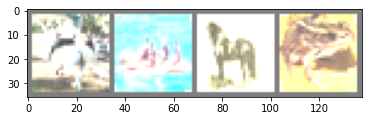

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
import torch.nn as nn

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size = 3, padding = "same",stride=1, dilation=1,bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, stride=stride,padding=padding,dilation=dilation, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1,bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [32]:
from model import Net

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 16, 26, 26]           2,304
            Conv2d-6           [-1, 32, 26, 26]             512
depthwise_separable_conv-7           [-1, 32, 26, 26]               0
              ReLU-8           [-1, 32, 26, 26]               0
       BatchNorm2d-9           [-1, 32, 26, 26]              64
          Dropout-10           [-1, 32, 26, 26]               0
           Conv2d-11           [-1, 32, 22, 22]           9,216
           Conv2d-12           [-1, 32, 22, 22]          

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

In [17]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    test(model, device, testloader)

EPOCH: 0


Loss=2.5588433742523193 Batch_id=12499 Accuracy=35.47: 100%|██████████| 12500/12500 [03:05<00:00, 67.52it/s]



Test set: Average loss: 0.3594, Accuracy: 4921/10000 (49.21%)

EPOCH: 1


Loss=2.391526222229004 Batch_id=12499 Accuracy=44.72: 100%|██████████| 12500/12500 [03:01<00:00, 69.01it/s]



Test set: Average loss: 0.3278, Accuracy: 5391/10000 (53.91%)

EPOCH: 2


Loss=1.1631410121917725 Batch_id=12499 Accuracy=48.99: 100%|██████████| 12500/12500 [02:58<00:00, 69.98it/s]



Test set: Average loss: 0.3001, Accuracy: 5849/10000 (58.49%)

EPOCH: 3


Loss=1.6102139949798584 Batch_id=12499 Accuracy=52.01: 100%|██████████| 12500/12500 [02:58<00:00, 69.90it/s]



Test set: Average loss: 0.2842, Accuracy: 5954/10000 (59.54%)

EPOCH: 4


Loss=2.137784957885742 Batch_id=12499 Accuracy=54.89: 100%|██████████| 12500/12500 [02:59<00:00, 69.60it/s]



Test set: Average loss: 0.2759, Accuracy: 6189/10000 (61.89%)

EPOCH: 5


Loss=1.0353155136108398 Batch_id=12499 Accuracy=56.19: 100%|██████████| 12500/12500 [02:59<00:00, 69.81it/s]



Test set: Average loss: 0.2631, Accuracy: 6331/10000 (63.31%)

EPOCH: 6


Loss=2.2583305835723877 Batch_id=12499 Accuracy=60.55: 100%|██████████| 12500/12500 [02:58<00:00, 70.01it/s]



Test set: Average loss: 0.2383, Accuracy: 6662/10000 (66.62%)

EPOCH: 7


Loss=0.49761176109313965 Batch_id=12499 Accuracy=61.72: 100%|██████████| 12500/12500 [02:59<00:00, 69.49it/s]



Test set: Average loss: 0.2369, Accuracy: 6716/10000 (67.16%)

EPOCH: 8


Loss=2.487778663635254 Batch_id=12499 Accuracy=61.99: 100%|██████████| 12500/12500 [02:59<00:00, 69.54it/s]



Test set: Average loss: 0.2343, Accuracy: 6723/10000 (67.23%)

EPOCH: 9


Loss=0.8206443190574646 Batch_id=12499 Accuracy=62.15: 100%|██████████| 12500/12500 [03:05<00:00, 67.49it/s]



Test set: Average loss: 0.2295, Accuracy: 6800/10000 (68.00%)

EPOCH: 10


Loss=0.715792715549469 Batch_id=12499 Accuracy=62.65: 100%|██████████| 12500/12500 [03:02<00:00, 68.59it/s]



Test set: Average loss: 0.2314, Accuracy: 6802/10000 (68.02%)

EPOCH: 11


Loss=1.0757040977478027 Batch_id=12499 Accuracy=63.19: 100%|██████████| 12500/12500 [02:59<00:00, 69.75it/s]



Test set: Average loss: 0.2291, Accuracy: 6860/10000 (68.60%)

EPOCH: 12


Loss=0.744814395904541 Batch_id=12499 Accuracy=63.97: 100%|██████████| 12500/12500 [02:59<00:00, 69.55it/s]



Test set: Average loss: 0.2269, Accuracy: 6860/10000 (68.60%)

EPOCH: 13


Loss=0.35308030247688293 Batch_id=12499 Accuracy=63.91: 100%|██████████| 12500/12500 [02:58<00:00, 69.84it/s]



Test set: Average loss: 0.2287, Accuracy: 6852/10000 (68.52%)

EPOCH: 14


Loss=0.6351791620254517 Batch_id=12499 Accuracy=64.09: 100%|██████████| 12500/12500 [02:59<00:00, 69.46it/s]



Test set: Average loss: 0.2261, Accuracy: 6920/10000 (69.20%)



In [30]:
len(test_acc)

15

Text(0.5, 1.0, 'Test Accuracy')

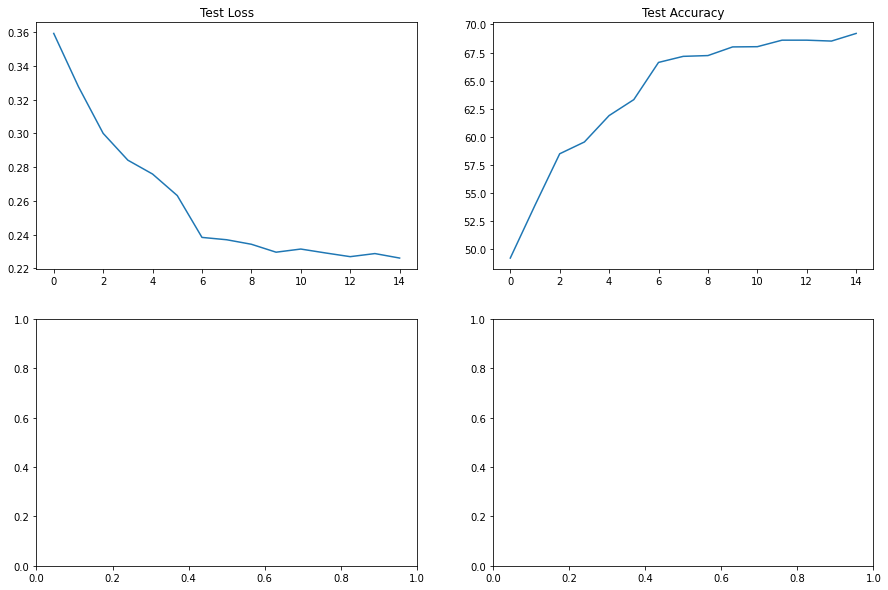

In [31]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
# axs[0, 0].plot(t)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy")
axs[0, 0].plot(test_losses)
axs[0, 0].set_title("Test Loss")
axs[0, 1].plot(test_acc)
axs[0, 1].set_title("Test Accuracy")